# COMP 579 Assignment 1

Deadline: Thursday, January 25th, 2024

Author:
* Ali Karami: ali.karami@mcgill.ca


In [19]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import math


plt.rcParams["figure.figsize"]=10,5

## Q1 Simulator for Bernoulli Bandit

In [20]:
class BernoulliBandit:
  """
  A class for Bernoulli multi-armed bandit.

  Attributes
  ----------
  num_arms : int
      The number of arms in the bernoulli bandit
  probs_arr : array of integer (size num_arms)
      The binomial distribution parameter p_k (probability of drawing 1) of each arm indexed from 0

  Methods
  -------
  sample(arm_index)
      Returns a reward sample of the binomial distribution indexed by the arm_index (return 0 with probability
      1-probs_arr[k] and 1 with probability probs_arr[k])
  """

  def __init__(self, num_arms, probs_arr):
    self.num_arms = """ YOUR CODE GOES HERE """
    self.probs_arr = """ YOUR CODE GOES HERE """

  def sample(self, arm_index):
    return """ YOUR CODE GOES HERE """

In [21]:
delta = 0.1
num_arms = 3
probs_arr = [0.5+delta, 0.5, 0.5-delta]
num_samples = 50

three_arm_bernoulli_bandit = """ YOUR CODE GOES HERE """
actions = range(num_arms)

action_rewards = []
for action in actions:
  # store 50 samples per action
  rewards = """ YOUR CODE GOES HERE """
  action_rewards.append(rewards)

### Graphs

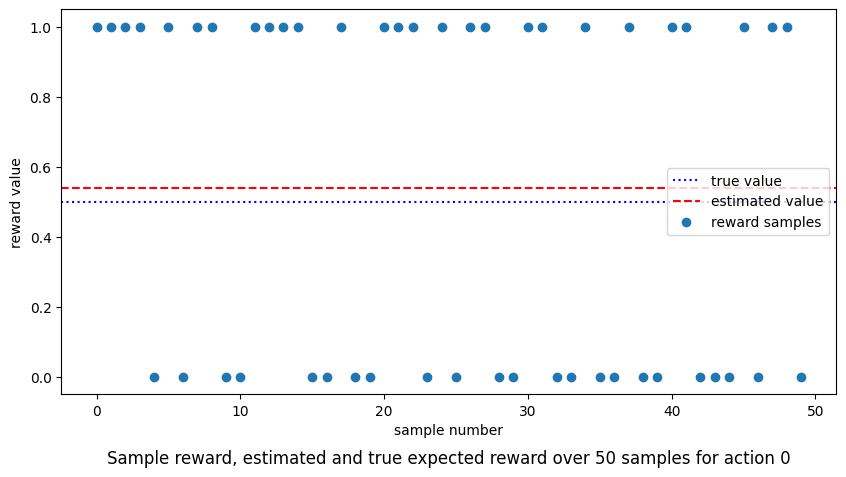

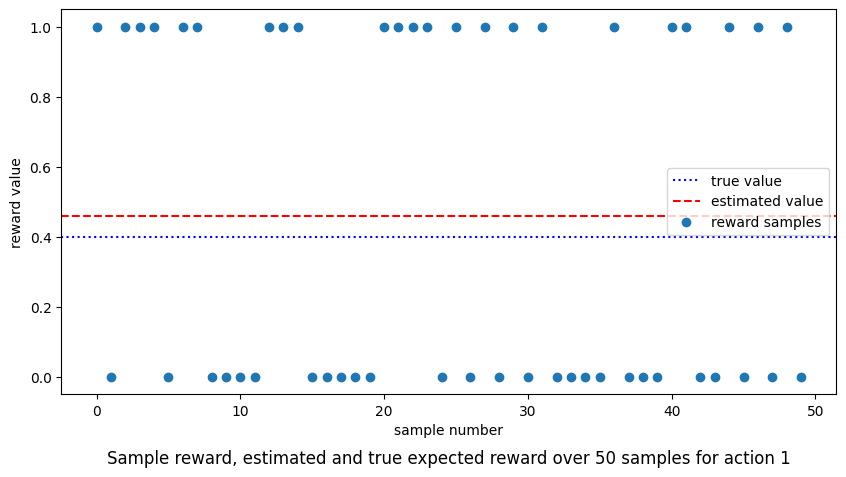

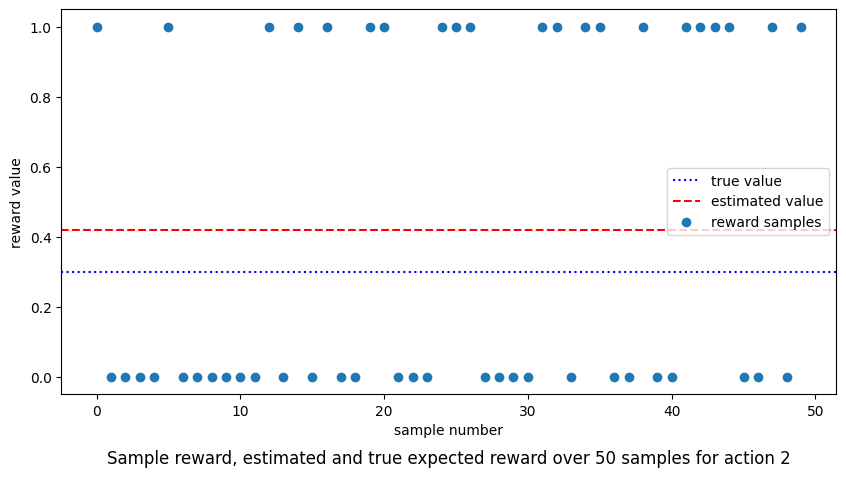

In [22]:
for action in actions:
  fig, ax = plt.subplots()

  true_value = """ YOUR CODE GOES HERE """
  estimated_value = """ YOUR CODE GOES HERE """

  # draw the line of the true value
  line_true_val = ax.axhline(y = true_value, color = 'b', linestyle = ':', label = "true value")
  # draw the line of the estimated value
  line_est_val = ax.axhline(y = estimated_value, color = 'r', linestyle = '--', label = "estimated value")
  # plot the reward samples
  plt_samples, = ax.plot(action_rewards[action], 'o', label = "reward samples")

  ax.set_xlabel("sample number")
  ax.set_ylabel("reward value")
  ax.set_title("Sample reward, estimated and true expected reward over 50 samples for action %s" %action, y=-0.2)

  # show the legend with the labels of the line
  ax.legend(handles=[line_true_val, line_est_val, plt_samples])

## Q2 Estimated Q values

In [24]:
def update(reward_samples, alpha):
  """
  Each call to the function yields the current incremental average of the reward with a fixed learning rate, alpha
  E.g. Inital call returns alpha * reward_samples[0], second call returns prev_val + alpha * (reward_samples[1] - prev_val)
  where prev_val is the value return from the previous call, so on and so forth

  Parameters
  ----------
  reward_samples : array of int
      samples of reward values from one arm of a bandit
  alpha : int
      learning rate parameter for the averaging
  """
  prev_val = 0
  for sample in reward_samples:
    new_val = """ YOUR CODE GOES HERE """
    prev_val = new_val
    yield new_val

def updateAvg(reward_samples):
  """
  Each call to the function yields the current incremental average of the reward
  E.g. Inital call returns reward_samples[0], second call returns the average of reward_samples[0] and reward_samples[0], so on and so forth

  Parameters
  ----------
  reward_samples : array of int
      samples of reward values from one arm of a bandit
  """
  prev_val = reward_samples[0]
  n = 1
  # first iteration only updates n to 2, no update to average
  for sample in reward_samples:
    new_val = """ YOUR CODE GOES HERE """
    prev_val = new_val
    n = """ YOUR CODE GOES HERE """
    yield new_val

### Graphs

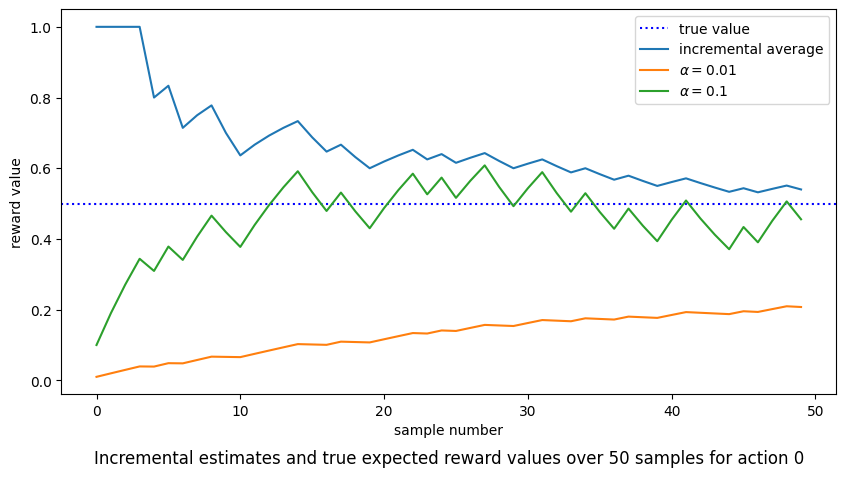

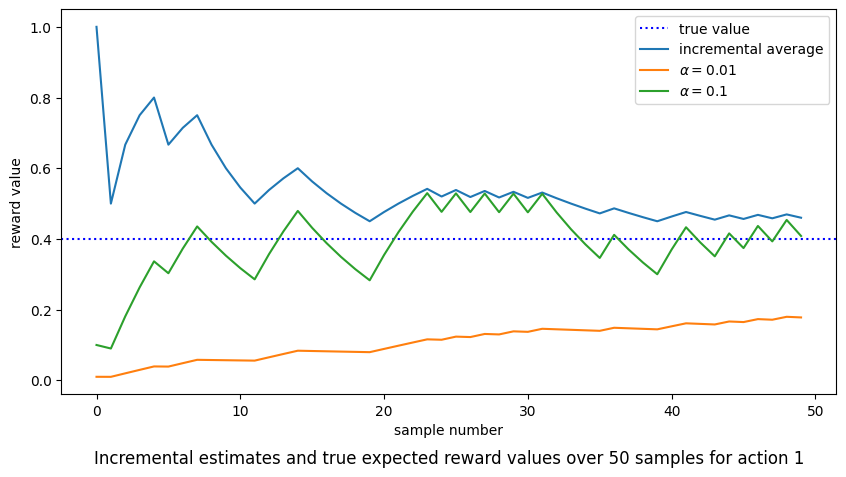

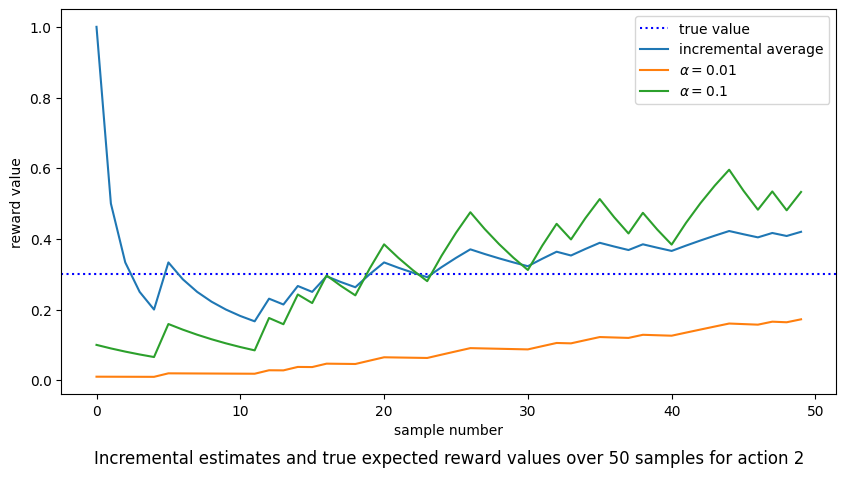

In [25]:
for action in actions:
  fig, ax = plt.subplots()

  # obtain incremental values for averaging, alpha = 0.01, alpha = 0.1
  incr_avgs = list(""" YOUR CODE GOES HERE """)
  alpha_1_percent = list(""" YOUR CODE GOES HERE """)
  alpha_10_percent = list(""" YOUR CODE GOES HERE """)

  true_value = probs_arr[action]

  # draw the true value line
  line_true_val = ax.axhline(y = true_value, color = 'b', linestyle = ':', label = "true value")

  # plot incremental values for averaging, alpha = 0.01, alpha = 0.1
  plt_incr_avgs, = ax.plot(incr_avgs, label = "incremental average")
  plt_alpha_1_percent, = ax.plot(alpha_1_percent, label = r"$\alpha = 0.01$")
  plt_alpha_10_percent, = ax.plot(alpha_10_percent, label = r"$\alpha = 0.1$")

  ax.set_xlabel("sample number")
  ax.set_ylabel("reward value")
  ax.set_title("Incremental estimates and true expected reward values over 50 samples for action %s" %action, y=-0.2)

  # show the legend with the labels of the line
  ax.legend(handles=[line_true_val, plt_incr_avgs, plt_alpha_1_percent, plt_alpha_10_percent])

## Q3 Effect of $α$ on Estimated Q values

In [26]:
num_samples = 100

# arrays of the data generated from 100 runs
incr_avgs_runs = []
alpha_1_percent_runs = []
alpha_10_percent_runs = []

for run in range(100):
  # arrays of data generated from the 3 actions in 1 run
  sample_incr_avgs_by_actions = []
  sample_alpha_1_percent_by_actions = []
  sample_alpha_10_percent_by_actions = []

  for action in actions:
    rewards = [""" YOUR CODE GOES HERE """]

    sample_incr_avgs_by_actions.append(list(""" YOUR CODE GOES HERE """))
    sample_alpha_1_percent_by_actions.append(list(""" YOUR CODE GOES HERE """))
    sample_alpha_10_percent_by_actions.append(list(""" YOUR CODE GOES HERE """))

  incr_avgs_runs.append(sample_incr_avgs_by_actions)
  alpha_1_percent_runs.append(sample_alpha_1_percent_by_actions)
  alpha_10_percent_runs.append(sample_alpha_10_percent_by_actions)

# convert to np arrays
incr_avgs_runs = np.asarray(incr_avgs_runs)
alpha_1_percent_runs = np.asarray(alpha_1_percent_runs)
alpha_10_percent_runs = np.asarray(alpha_10_percent_runs)

### Graphs

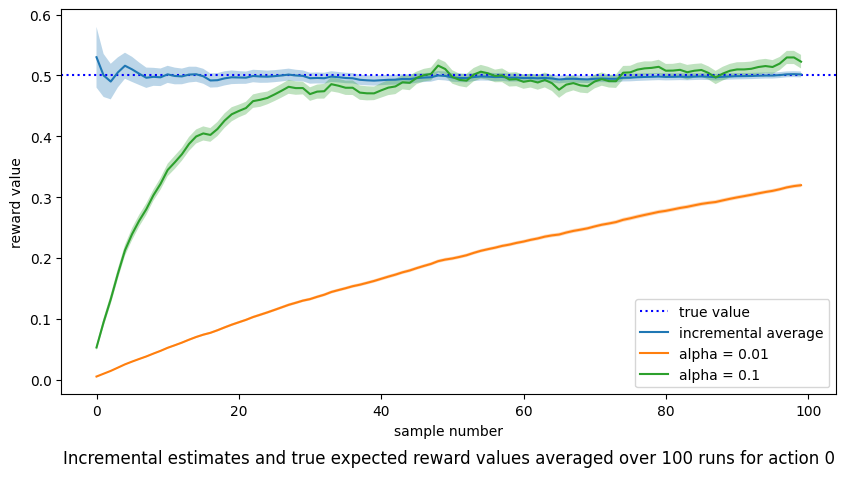

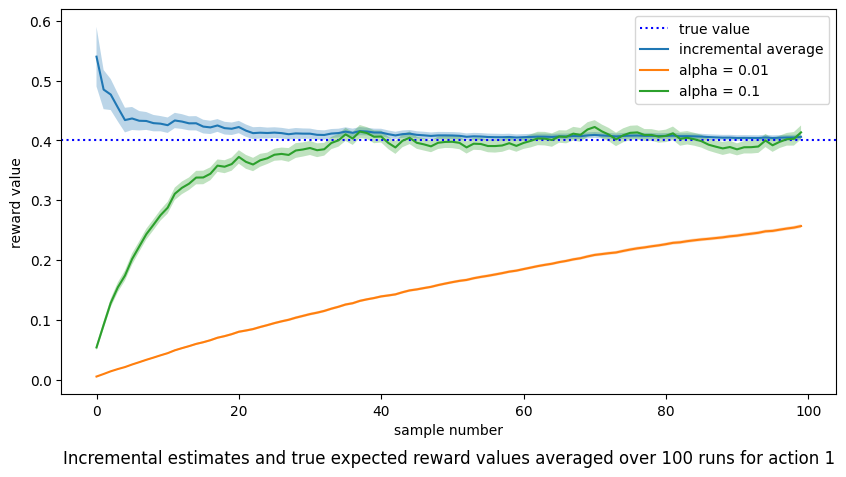

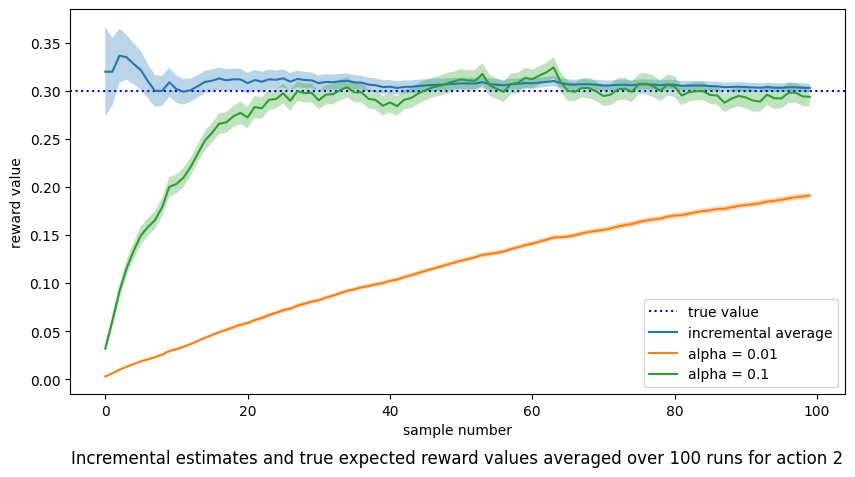

In [27]:
for action in actions:
  fig, ax = plt.subplots()

  # obtain averaged incremental reward values for averaging, alpha = 0.01, alpha = 0.1 over 100 runs
  mean_incr_avgs_by_actions = np.mean(incr_avgs_runs[:,action,:], axis=0)
  mean_alpha_1_percent_by_actions = np.mean(alpha_1_percent_runs[:,action,:], axis=0)
  mean_alpha_10_percent_by_actions = np.mean(alpha_10_percent_runs[:,action,:], axis=0)
  true_value = probs_arr[action]

  # obtain the standard deviation for averaging, alpha = 0.01, alpha = 0.1 over 100 runs
  std_incr_avgs_by_actions = np.std(incr_avgs_runs[:,action,:], axis=0)
  std_alpha_1_percent_by_actions = np.std(alpha_1_percent_runs[:,action,:], axis=0)
  std_alpha_10_percent_by_actions = np.std(alpha_10_percent_runs[:,action,:], axis=0)

  # obtain the standard error for averaging, alpha = 0.01, alpha = 0.1 over 100 runs
  std_err_incr_avgs_by_actions = np.std(incr_avgs_runs[:,action,:], axis=0) / np.sqrt(np.size(incr_avgs_runs[:,action,:], axis=0))
  std_err_alpha_1_percent_by_actions = np.std(alpha_1_percent_runs[:,action,:], axis=0) / np.sqrt(np.size(alpha_1_percent_runs[:,action,:], axis=0))
  std_err_alpha_10_percent_by_actions = np.std(alpha_10_percent_runs[:,action,:], axis=0) / np.sqrt(np.size(alpha_10_percent_runs[:,action,:], axis=0))

  # draw the true value line
  line_true_val = ax.axhline(y = true_value, color = 'b', linestyle = ':', label = "true value")

  # draw the averaged incremental reward values for averaging
  plt_incr_avgs, = ax.plot(mean_incr_avgs_by_actions, label = "incremental average")
  # draw the error bar/area for averaging
  incr_avgs_minus_std_err = mean_incr_avgs_by_actions - std_err_incr_avgs_by_actions
  incr_avgs_plus_std_err = mean_incr_avgs_by_actions + std_err_incr_avgs_by_actions
  ax.fill_between(range(0,100), incr_avgs_minus_std_err, incr_avgs_plus_std_err, alpha=0.3)

  # draw the averaged incremental reward values for alpha = 0.01
  plt_alpha_1_percent, = ax.plot(mean_alpha_1_percent_by_actions, label = "alpha = 0.01")
  # draw the error bar/area for alpha = 0.01
  alpha_1_percent_minus_std_err = mean_alpha_1_percent_by_actions - std_err_alpha_1_percent_by_actions
  alpha_1_percent_plus_std_err = mean_alpha_1_percent_by_actions + std_err_alpha_1_percent_by_actions
  ax.fill_between(range(0,100), alpha_1_percent_minus_std_err, alpha_1_percent_plus_std_err, alpha=0.3)

  # draw the averaged incremental reward values for alpha = 0.1
  plt_alpha_10_percent, = ax.plot(mean_alpha_10_percent_by_actions, label = "alpha = 0.1")
  # draw the error bar/area for alpha = 0.1
  alpha_10_percent_minus_std_err = mean_alpha_10_percent_by_actions - std_err_alpha_10_percent_by_actions
  alpha_10_percent_plus_std_err = mean_alpha_10_percent_by_actions + std_err_alpha_10_percent_by_actions
  ax.fill_between(range(0,100), alpha_10_percent_minus_std_err, alpha_10_percent_plus_std_err, alpha=0.3)

  ax.set_xlabel("sample number")
  ax.set_ylabel("reward value")
  ax.set_title("Incremental estimates and true expected reward values averaged over 100 runs for action %s" %action, y=-0.2)

  ax.legend(handles=[line_true_val, plt_incr_avgs, plt_alpha_1_percent, plt_alpha_10_percent])

### Answers

Put your asnwers here ...

## Q4 Epsilon-greedy

In [30]:
def epsilon_greedy(bandit, epsilon, alpha = None, num_time_step = 1000):
  """Epsilon greedy algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A bernoulli bandit attributes num_arms and probs_arr, and method sample
  epsilon: float
      A parameter which determines the probability for a random action to be selected
  alpha: (optional) float
      A parameter which determined the learning rate for averaging. If alpha is none, incremental averaging is used.
      Default is none, corresponding to incremental averaging.

  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  est_is_best_over_t
      a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
  l_over_t
      a list of instanteneous regret over the time steps
  total_l_over_t
      a list of cummulative regret over the time steps
  """

  num_arms = bandit.num_arms

  Q_arr = np.zeros(num_arms) # array of estimated average reward for each action
  N_arr = np.zeros(num_arms) # array of number of times picked for each action
  total_R = 0
  total_l = 0
  actions = range(num_arms)

  opt_value = max(""" YOUR CODE GOES HERE """)               # highest expected reward among all actions
  best_action = """ YOUR CODE GOES HERE """ # the index of the action with highest expected reward

  R_over_t = []
  total_R_over_t = []
  est_is_best_over_t = []
  l_over_t = []
  total_l_over_t = []

  for time_step in range(num_time_step):
    A_star = np.random.choice(""" YOUR CODE GOES HERE """)     # get action with highest estimated average reward with random tie-breaking
    A_random = np.random.choice(""" YOUR CODE GOES HERE """)
    A = np.random.choice([""" YOUR CODE GOES HERE """, """ YOUR CODE GOES HERE """], p=[""" YOUR CODE GOES HERE """, """ YOUR CODE GOES HERE """]) # pick a random action with probability epsilon
    curr_R = bandit.sample(A)
    N_arr[A] = N_arr[A] + 1

    if alpha == None:
      # incremental averaging
      Q_arr[A] = """ YOUR CODE GOES HERE """
    else:
      Q_arr[A] = """ YOUR CODE GOES HERE """

    R_over_t.append(curr_R)

    total_R = total_R + curr_R
    total_R_over_t.append(total_R)

    est_is_best = 1 if """ YOUR CODE GOES HERE """ else 0
    est_is_best_over_t.append(est_is_best)

    l_t = """ YOUR CODE GOES HERE """
    l_over_t.append(l_t)

    total_l = total_l + l_t
    total_l_over_t.append(total_l)

  return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

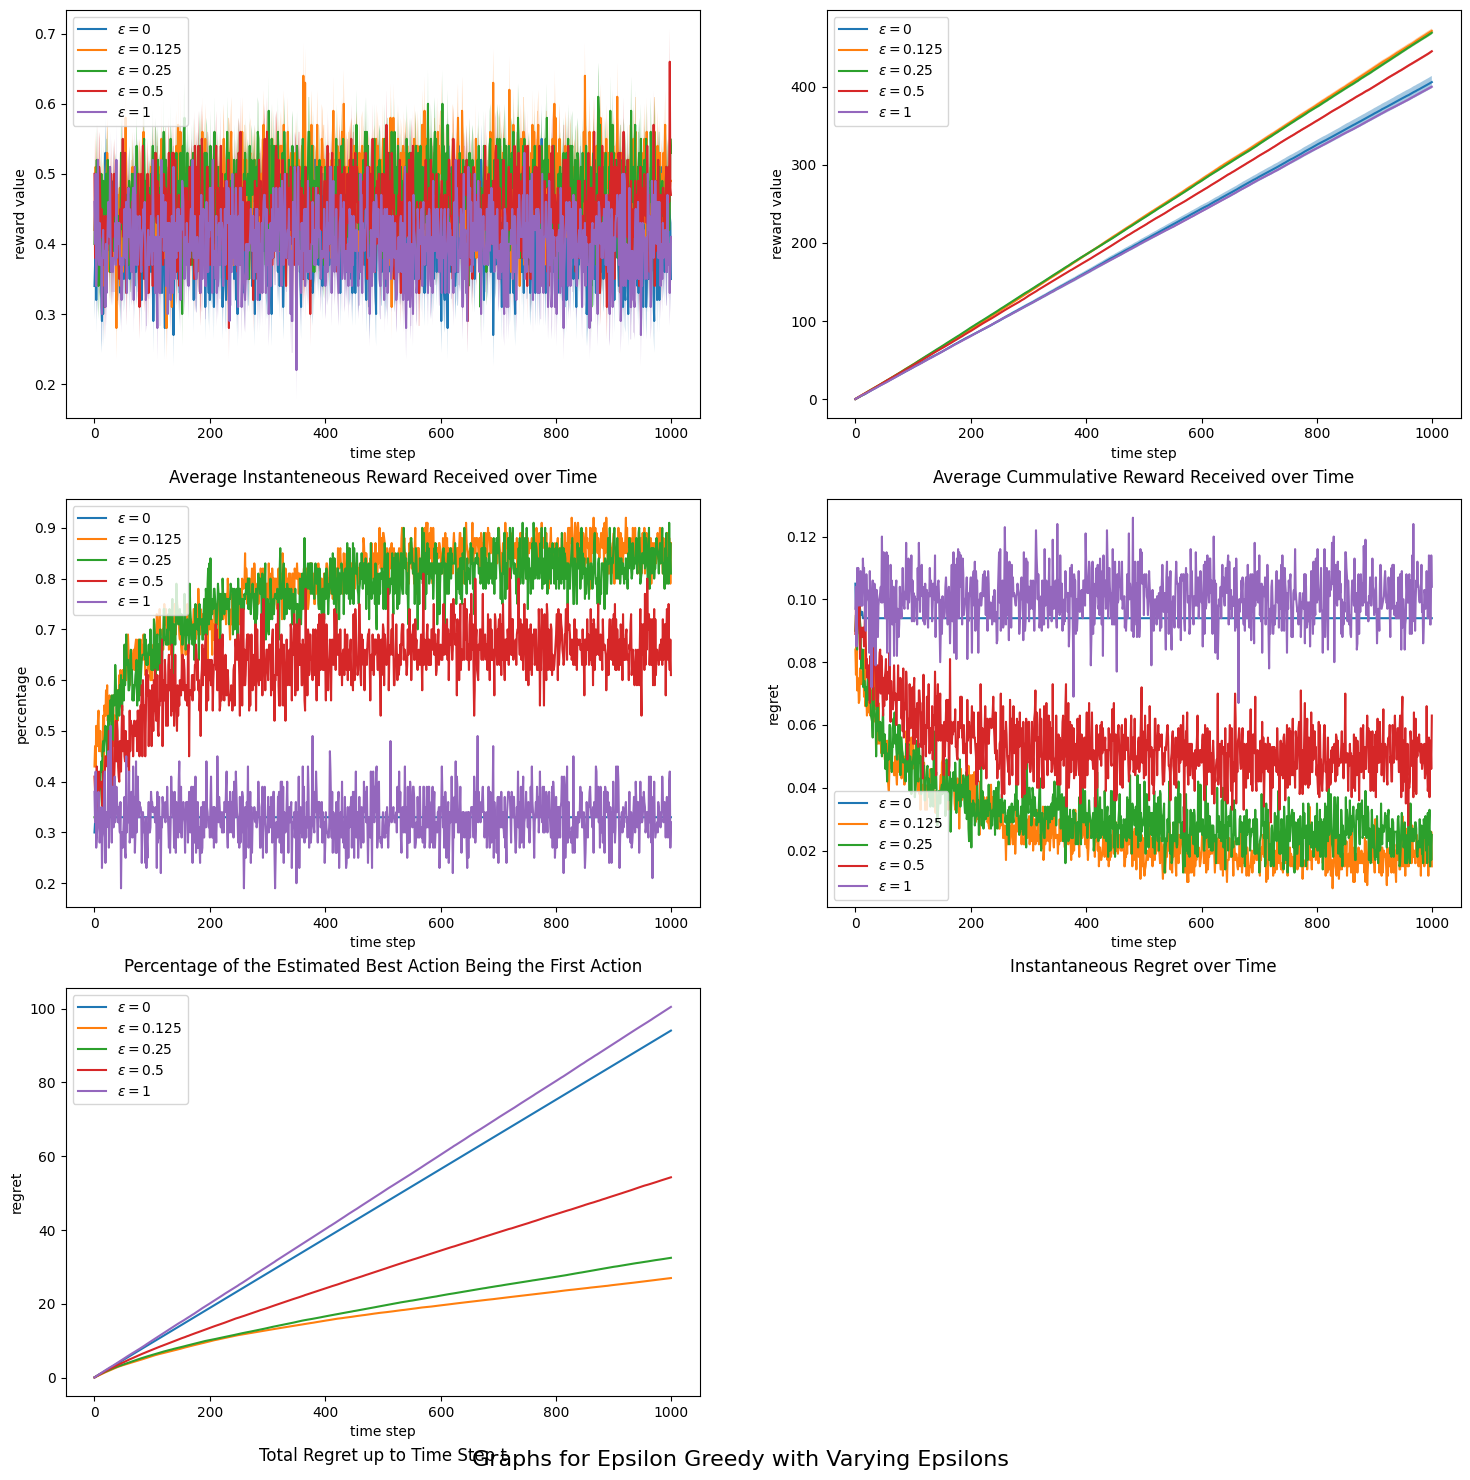

In [31]:
epsilons = """ YOUR CODE GOES HERE """

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for epsilon in epsilons:

  # arrays of the data generated from 100 runs
  R_over_t_runs = []
  total_R_over_t_runs = []
  est_is_best_over_t_runs = []
  l_over_t_runs = []
  total_l_over_t_runs = []

  for run in range(100):
    R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = epsilon_greedy(three_arm_bernoulli_bandit, epsilon)

    R_over_t_runs.append(R_over_t)
    total_R_over_t_runs.append(total_R_over_t)
    est_is_best_over_t_runs.append(est_is_best_over_t)
    l_over_t_runs.append(l_over_t)
    total_l_over_t_runs.append(total_l_over_t)

  R_over_t_runs = np.asarray(R_over_t_runs)
  total_R_over_t_runs = np.asarray(total_R_over_t_runs)
  est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
  l_over_t_runs = np.asarray(l_over_t_runs)
  total_l_over_t_runs = np.asarray(total_l_over_t_runs)

  # plot the mean reward over time

  mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
  std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(np.size(R_over_t_runs, axis=0))

  axs[0,0].plot(mean_R_over_t_runs, label = r"$\epsilon = %s$" %epsilon)

  R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
  R_over_t_plus_std_err = mean_R_over_t_runs  + std_err_R_over_t_runs
  axs[0,0].fill_between(range(0,1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4)
  # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

  axs[0,0].legend()
  axs[0,0].set_xlabel("time step")
  axs[0,0].set_ylabel("reward value")
  axs[0,0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

  # plot the mean cummulative reward over time

  mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
  std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(np.size(total_R_over_t_runs, axis=0))

  axs[0,1].plot(mean_total_R_over_t_runs, label = r"$\epsilon = %s$" %epsilon)

  total_R_over_t_minus_std_err = mean_total_R_over_t_runs - std_err_total_R_over_t_runs
  total_R_over_t_plus_std_err = mean_total_R_over_t_runs  + std_err_total_R_over_t_runs
  axs[0,1].fill_between(range(0,1000), total_R_over_t_minus_std_err, total_R_over_t_plus_std_err, alpha=0.4)

  axs[0,1].legend()
  axs[0,1].set_xlabel("time step")
  axs[0,1].set_ylabel("reward value")
  axs[0,1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

  #plot the mean percentage of the estimated best action being the first action

  est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
  plt_est_is_best_over_t_runs_avgs, = axs[1,0].plot(est_is_best_over_t_runs_avgs, label = r"$\epsilon = %s$" %epsilon)

  axs[1,0].legend()
  axs[1,0].set_xlabel("time step")
  axs[1,0].set_ylabel("percentage")
  axs[1,0].set_title("Percentage of the Estimated Best Action Being the First Action", y=-0.18)

  #plot the mean instantaneous regret over time

  l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
  axs[1,1].plot(l_over_t_runs_avgs, label = r"$\epsilon = %s$" %epsilon)

  axs[1,1].legend()
  axs[1,1].set_xlabel("time step")
  axs[1,1].set_ylabel("regret")
  axs[1,1].set_title("Instantaneous Regret over Time", y=-0.18)

  #plot the total regret over time

  total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
  axs[2,0].plot(total_l_over_t_runs_avgs, label = r"$\epsilon = %s$" %epsilon)

  axs[2,0].legend()
  axs[2,0].set_xlabel("time step")
  axs[2,0].set_ylabel("regret")
  axs[2,0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis('off')

title = r'Graphs for Epsilon Greedy with Varying Epsilons'
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Answers

Your answers goes here ...

##Q5 Hyperparameters for Epsilon-greedy

To have a plain start, you have been provided with predefined functions for generating plots until now. However, moving forward, you are expected to plot graphs on your own.

### Graphs

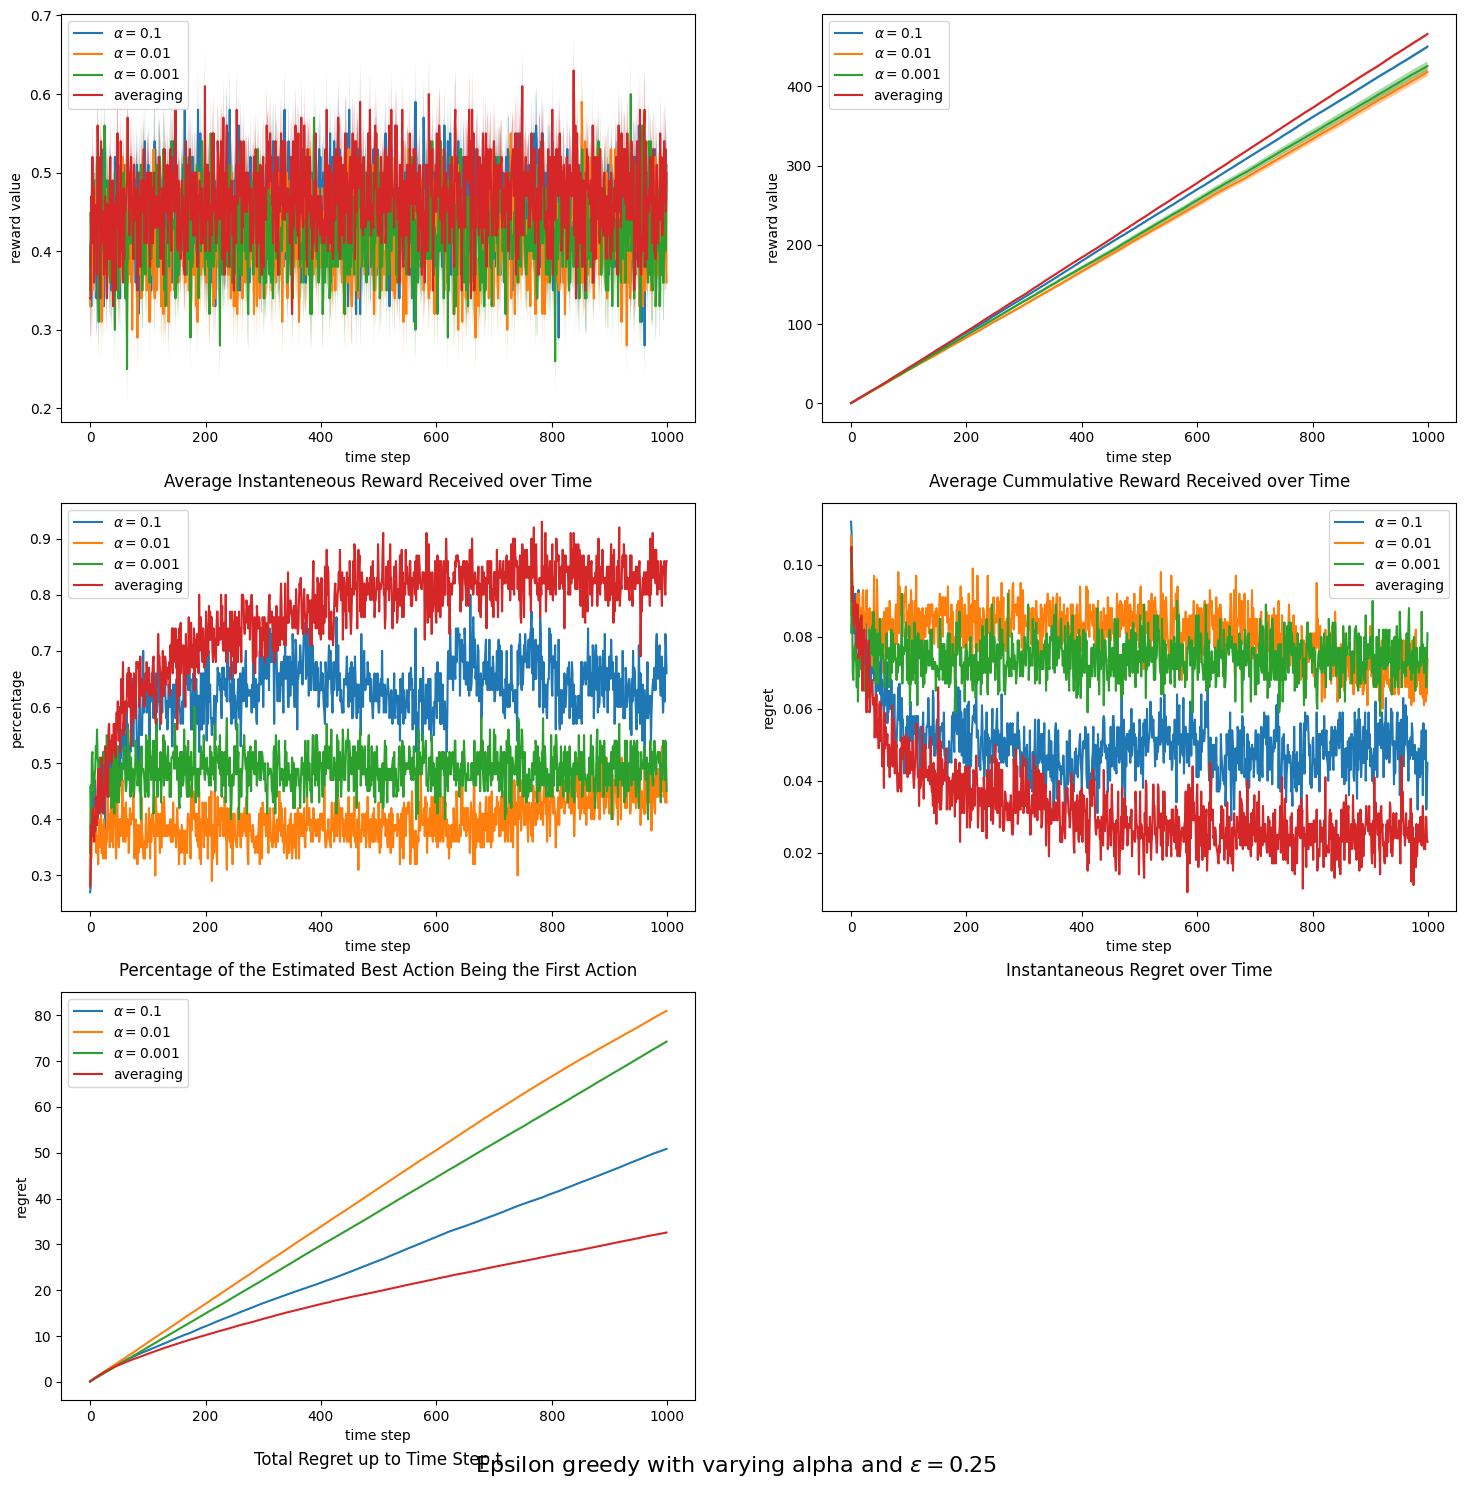

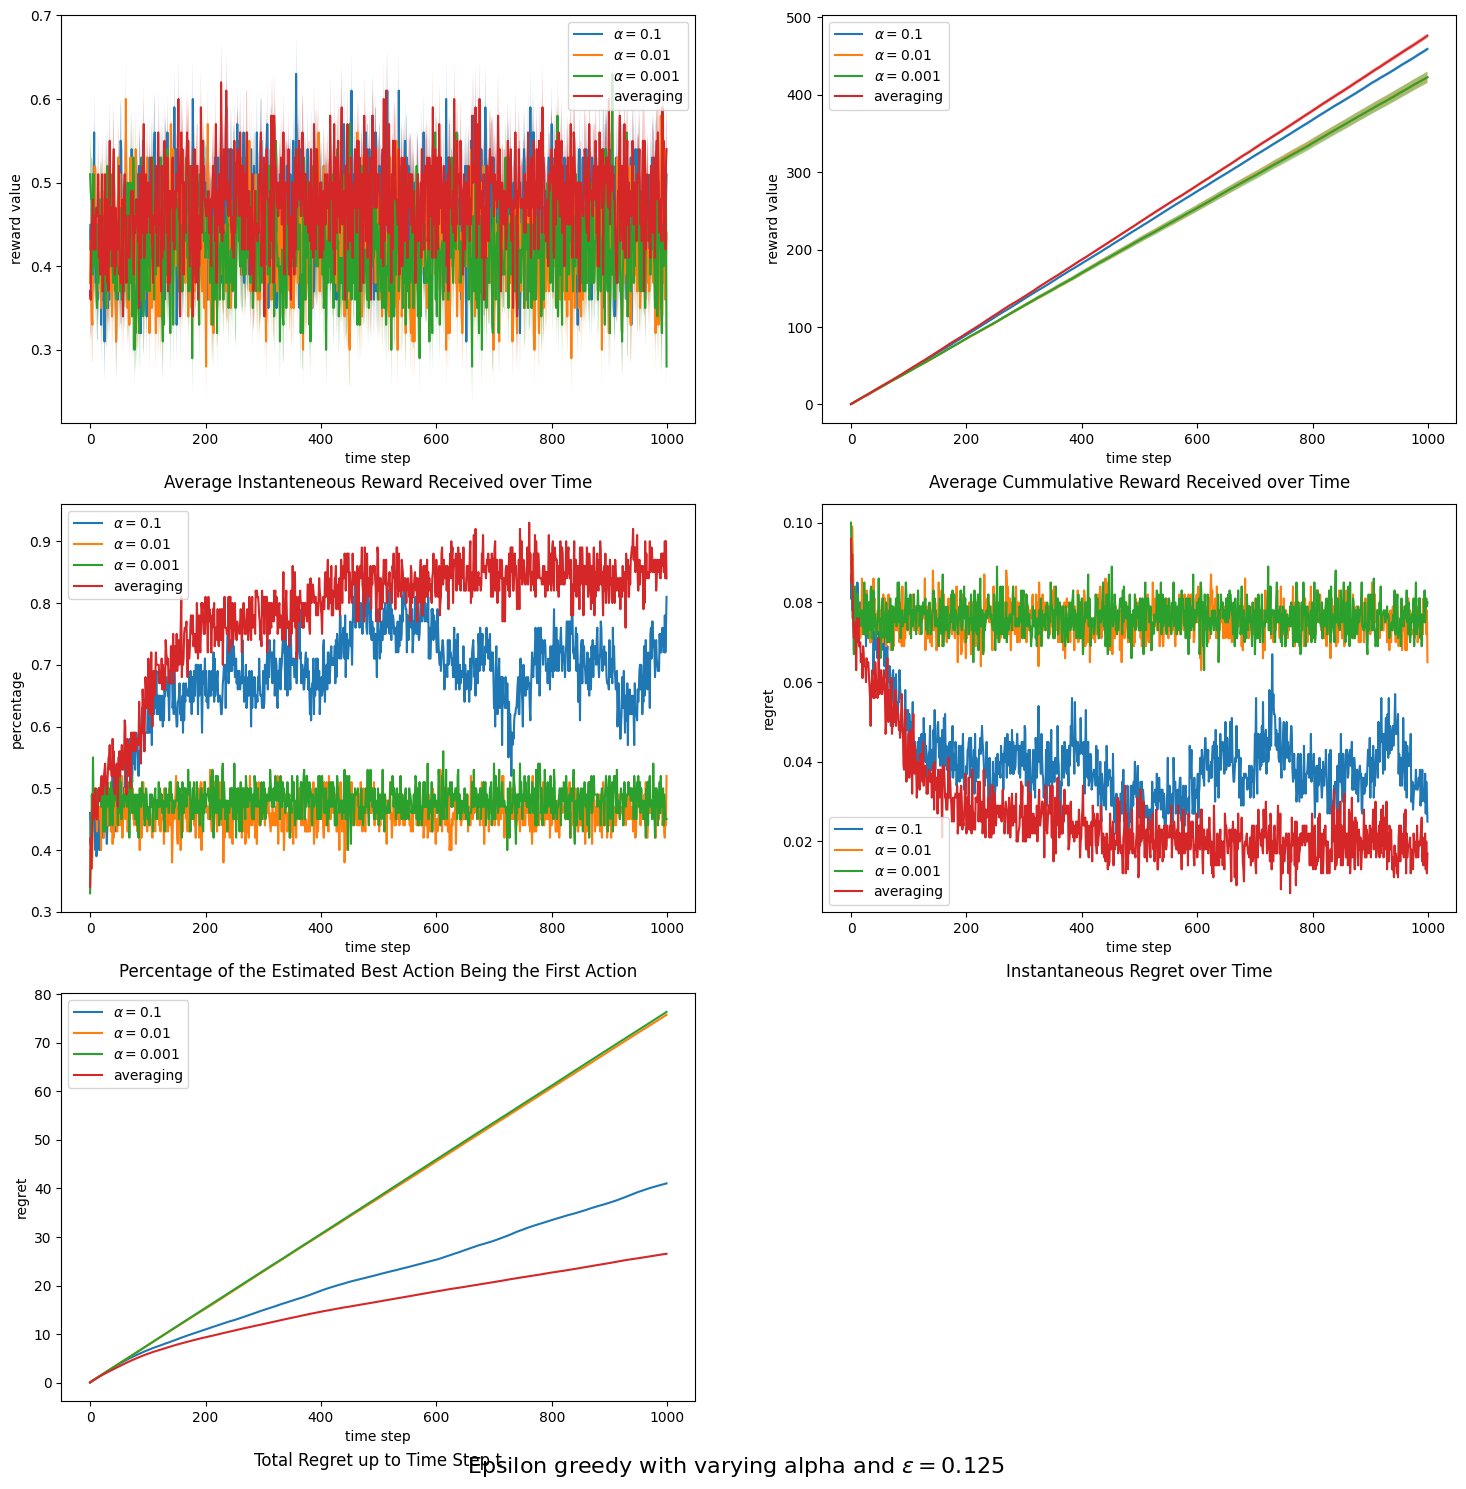

### Answers

Your answers goes here ...

## Q6 UCB

In [33]:
def UCB(bandit, c = 2, alpha = None, num_time_step = 1000):
  """Upper confidence bound algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A bernoulli bandit attributes num_arms and probs_arr, and method sample
  c: int
      A parameter which determines the degree of exploration, the higher the c the higher the tendency for
      the algorithm to explore potentially suboptimal actionss
  alpha: (optional) float
      A parameter which determined the learning rate for averaging. If alpha is none, incremental averaging is used.
      Default is none, corresponding to incremental averaging.

  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  est_is_best_over_t
      a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
  l_over_t
      a list of instanteneous regret over the time steps
  total_l_over_t
      a list of cummulative regret over the time steps
  """

  """ YOUR CODE GOES HERE """

  return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

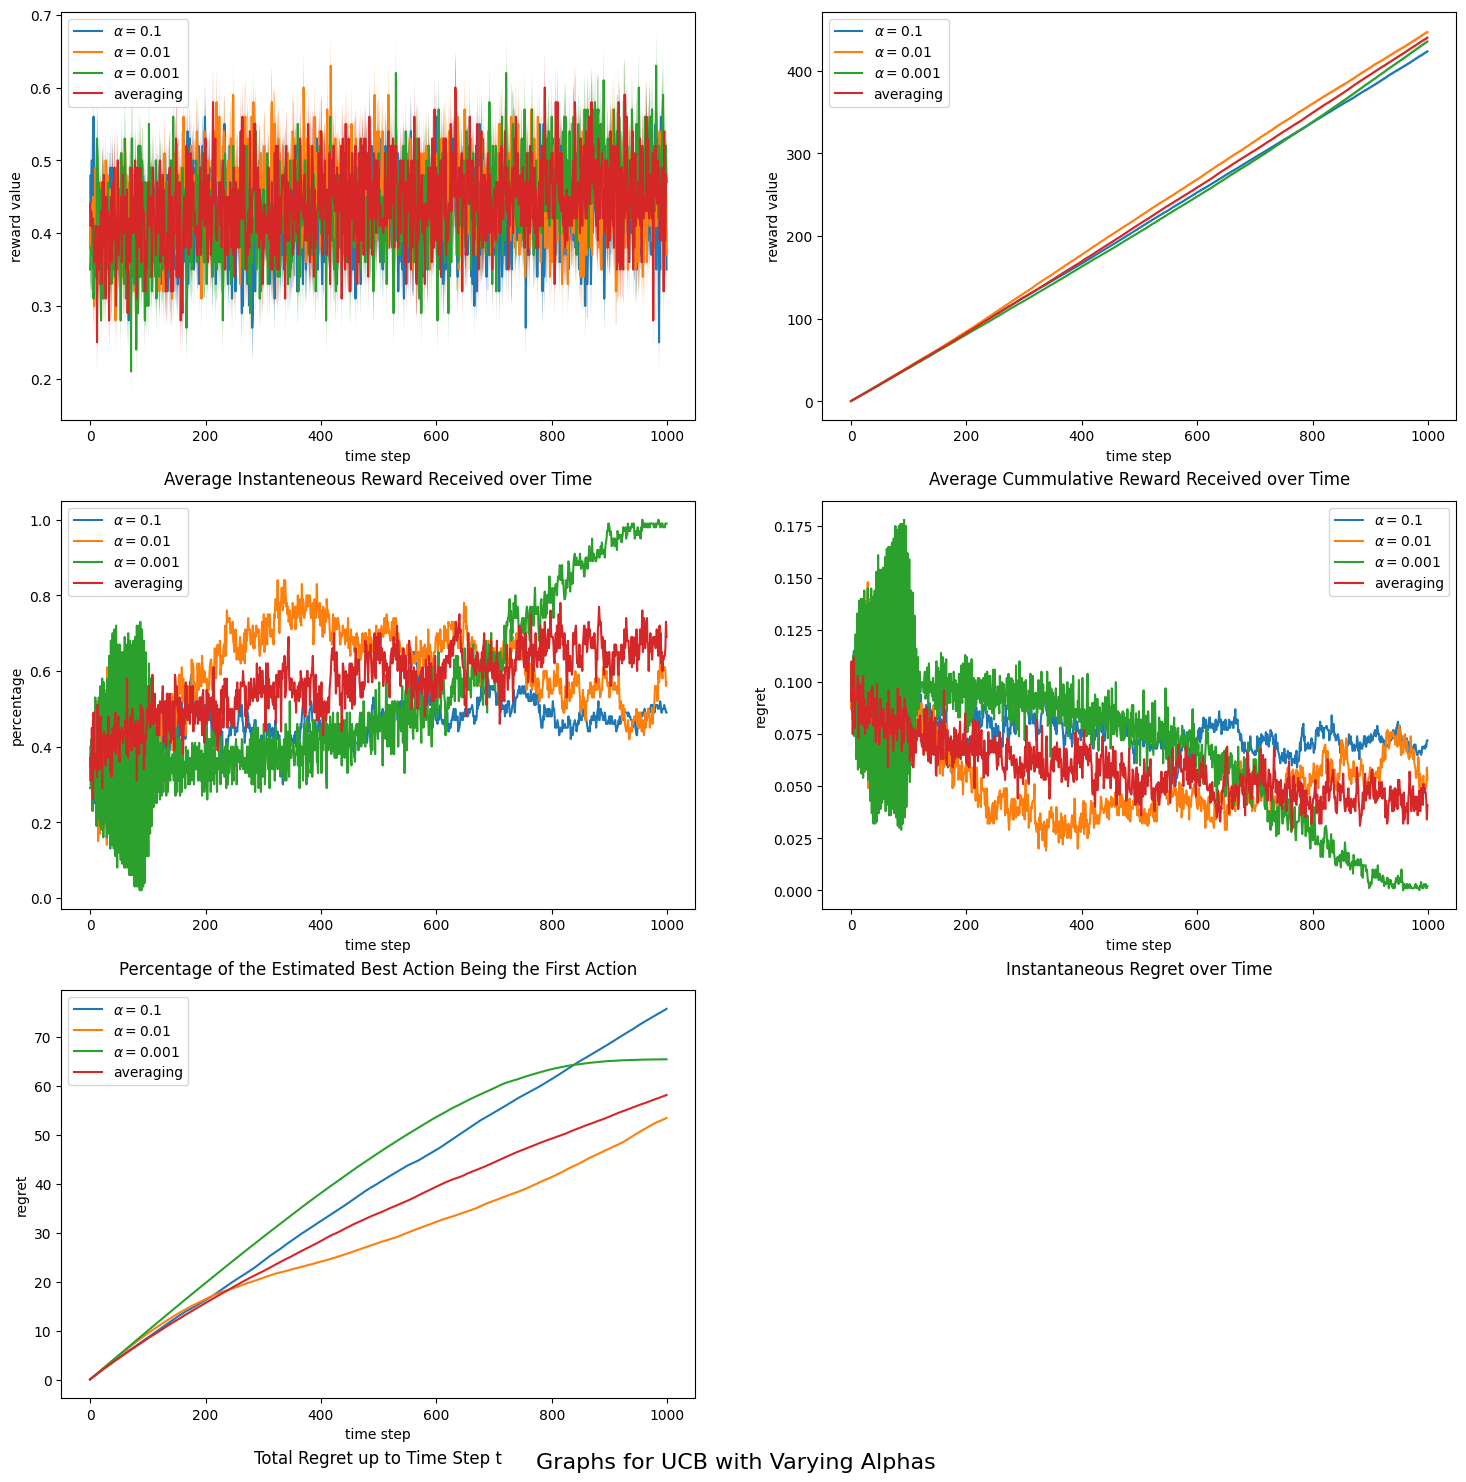

### Answers

Your answers goes here ...


## Q7 Thompson Sampling

In [35]:
def Thompson_sampling(bandit, num_time_step = 1000):
  """Thompson sampling algorithm for bandit action selection

  Parameters
  ----------
  bandit : bandit class
      A bernoulli bandit attributes num_arms and probs_arr, and method sample

  Returns
  -------
  R_over_t
      a list of instantaneous return over the time steps
  total_R_over_t
      a list of cummulative reward over the time steps
  est_is_best_over_t
      a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
  l_over_t
      a list of instanteneous regret over the time steps
  total_l_over_t
      a list of cummulative regret over the time steps
  """

  """ YOUR CODE GOES HERE """

  return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

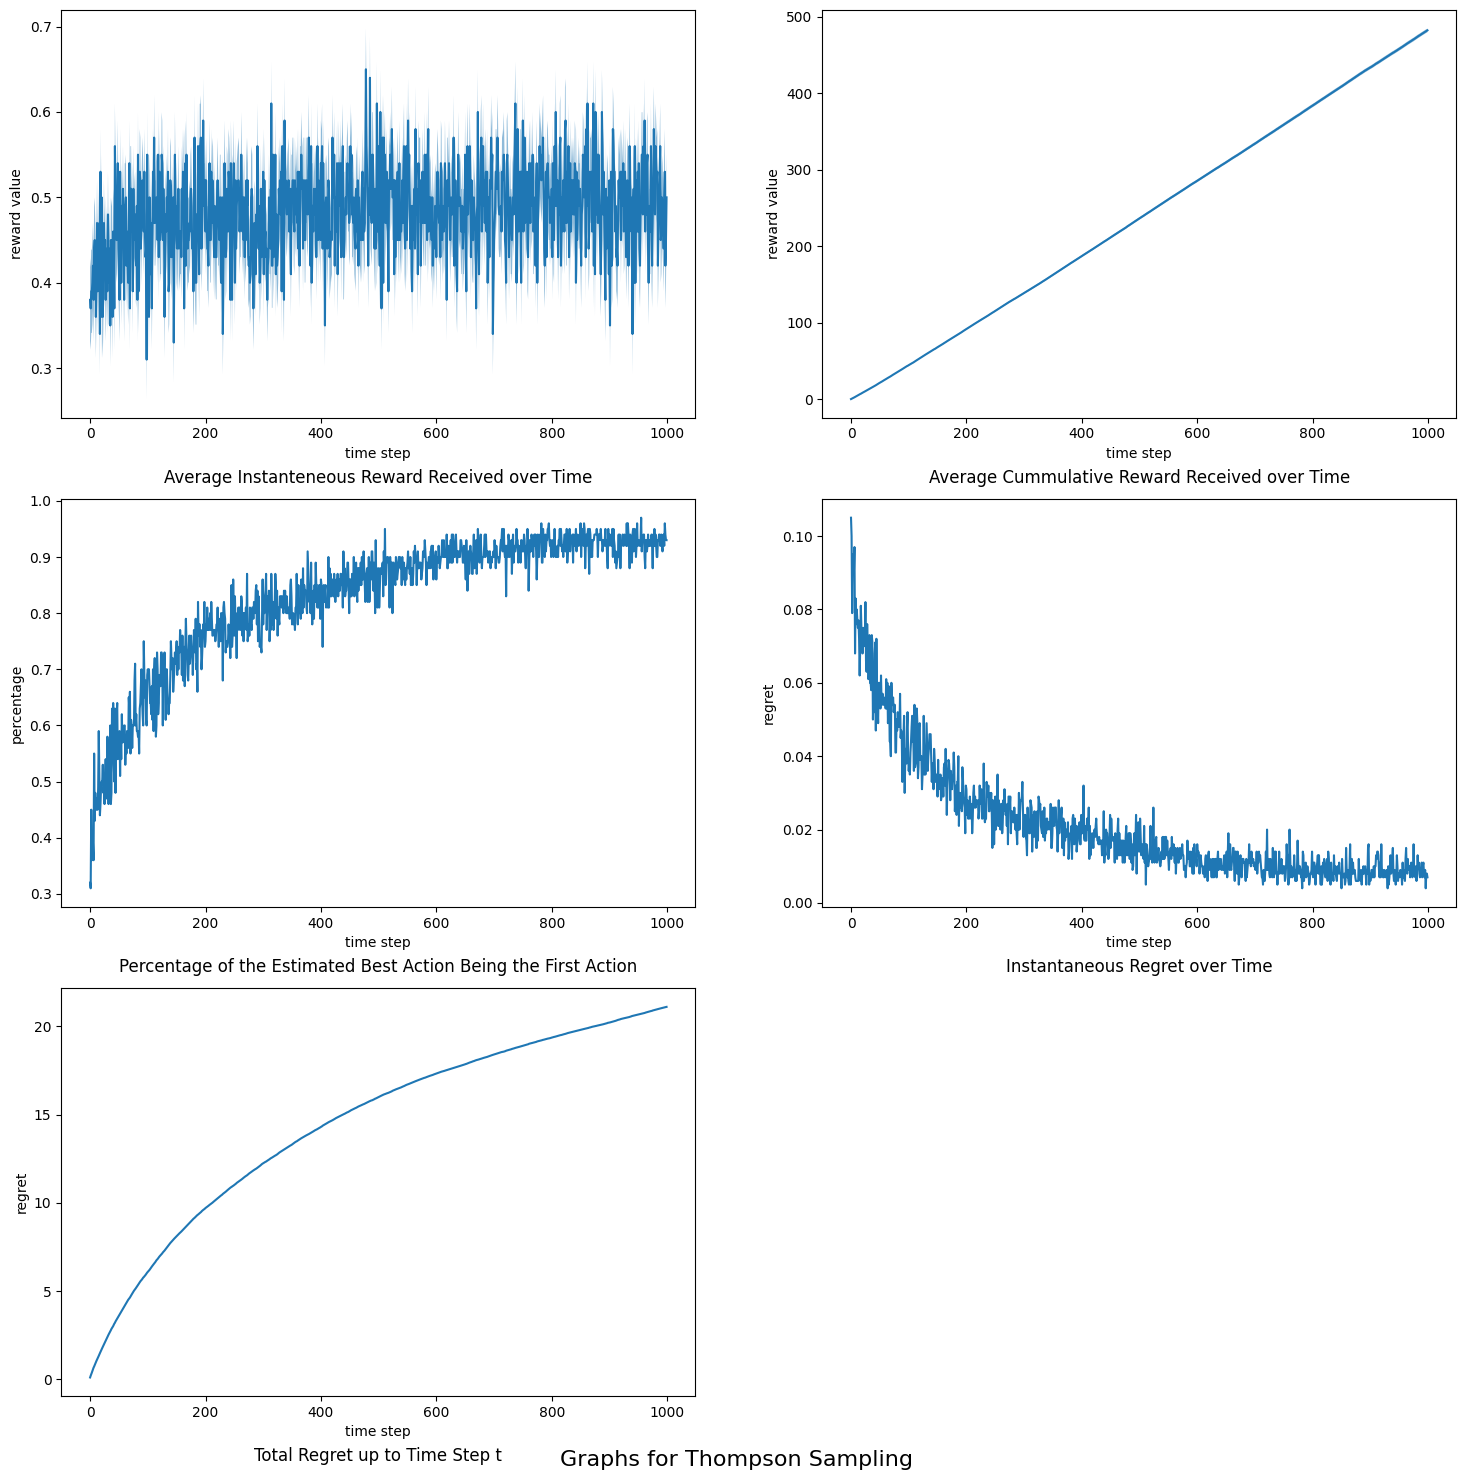

### Answers

Your answers goes here ...

## Q8 Comparison of Algorithms

### Graphs

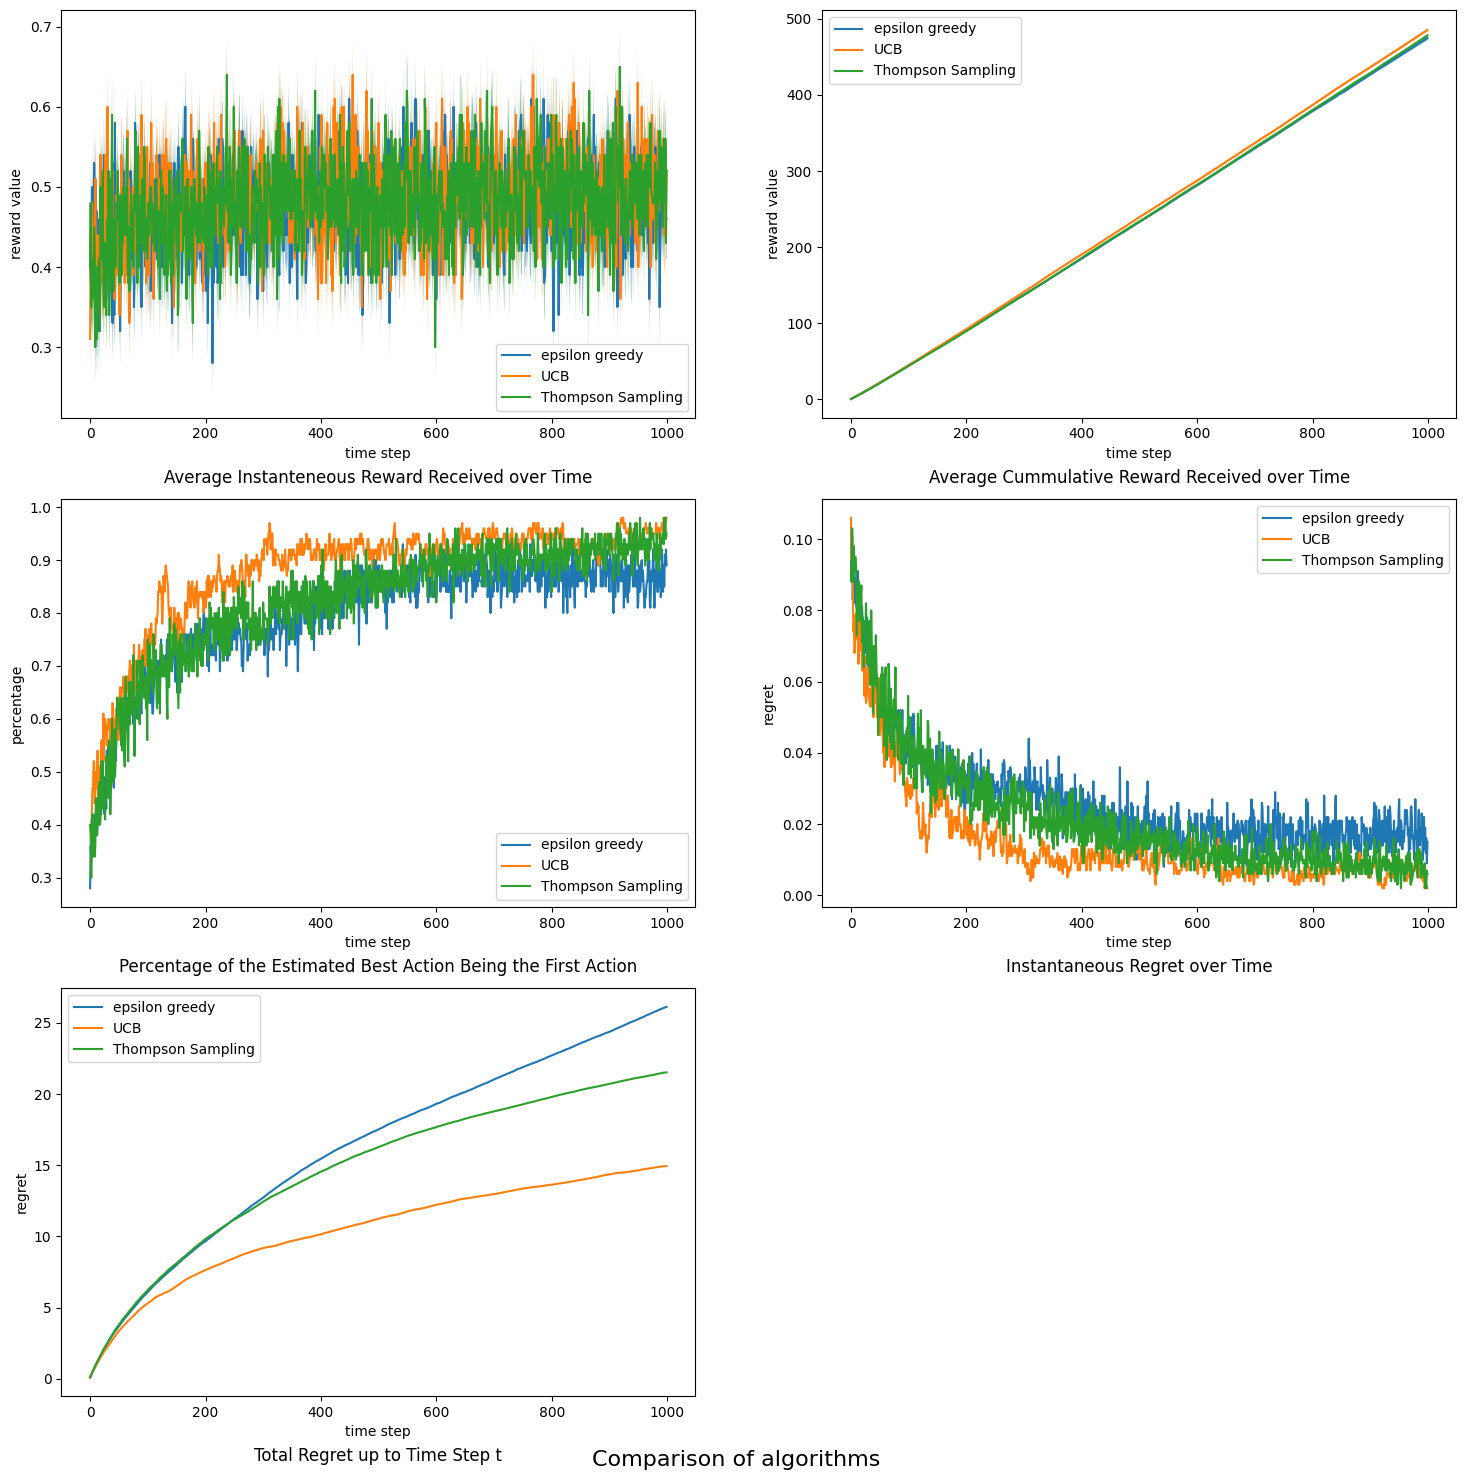

### Answers

Your answers goes here ...         

## Q9 Non-stationary Environment

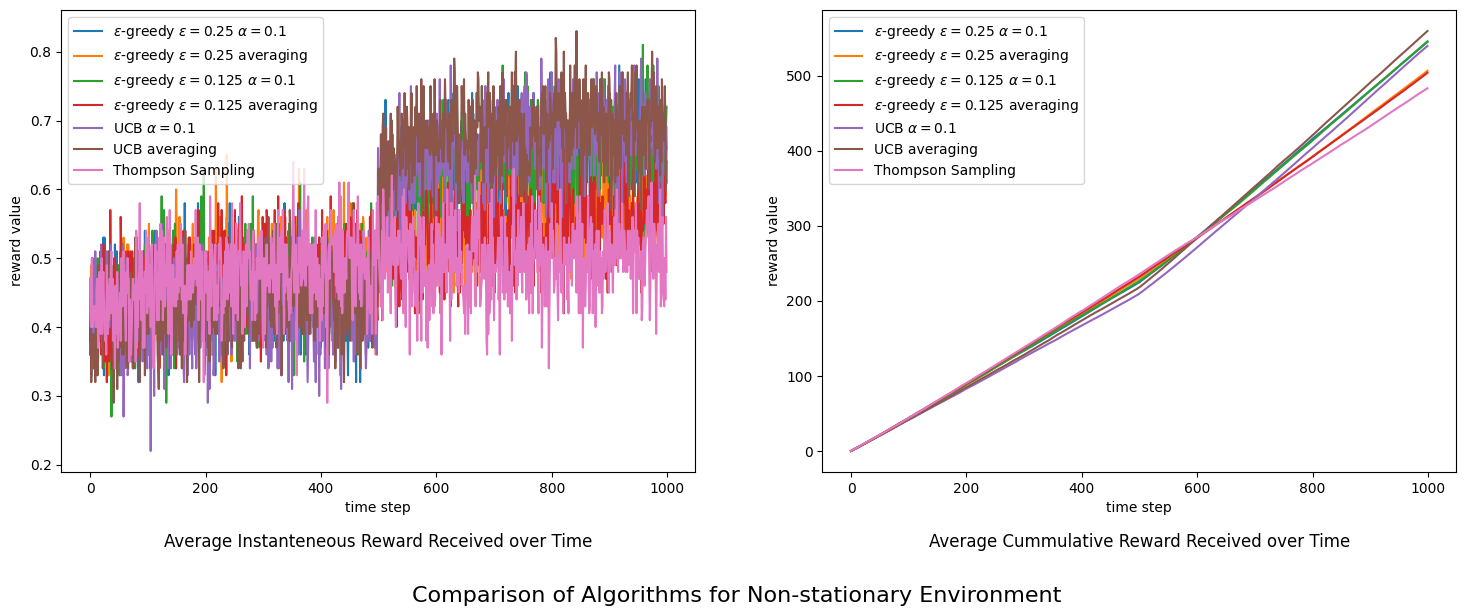

### Answers